In [1]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-a8de01e6-2323-f49a-5cf3-27f1982cc0f6)


# HandwrittenCalc

In [2]:
# !pip install imutils

import numpy as np 
import pandas as pd
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from imutils.contours import sort_contours
import imutils

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
import os

In [4]:
from helper_functions import unzip_data, walk_through_dir, create_tensorboard_callback, plot_loss_curves

In [5]:
unzip_data("new_totalDataset01.zip")

### 데이터 확인

In [6]:
import pathlib
import numpy as np

data_dir = pathlib.Path("new_totalDataset01")
class_names = np.array(
    sorted(
        [item.name for item in data_dir.glob("*")]
    )
)

print(class_names)

['%' '*' '+' '-' '.DS_Store' '0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [7]:
import os

for dirpath, dirnames, filenames in os.walk("new_totalDataset01"):
    print(f"{len(dirnames)}개의 디렉토리가 있으며, '{dirpath}'에는 {len(filenames)}개의 이미지가 있다.")

14개의 디렉토리가 있으며, 'new_totalDataset01'에는 1개의 이미지가 있다.
0개의 디렉토리가 있으며, 'new_totalDataset01/3'에는 22209개의 이미지가 있다.
0개의 디렉토리가 있으며, 'new_totalDataset01/*'에는 20721개의 이미지가 있다.
0개의 디렉토리가 있으며, 'new_totalDataset01/+'에는 22031개의 이미지가 있다.
0개의 디렉토리가 있으며, 'new_totalDataset01/4'에는 18819개의 이미지가 있다.
0개의 디렉토리가 있으며, 'new_totalDataset01/9'에는 18392개의 이미지가 있다.
0개의 디렉토리가 있으며, 'new_totalDataset01/8'에는 20838개의 이미지가 있다.
0개의 디렉토리가 있으며, 'new_totalDataset01/2'에는 20852개의 이미지가 있다.
0개의 디렉토리가 있으며, 'new_totalDataset01/0'에는 20845개의 이미지가 있다.
0개의 디렉토리가 있으며, 'new_totalDataset01/6'에는 19485개의 이미지가 있다.
0개의 디렉토리가 있으며, 'new_totalDataset01/-'에는 21946개의 이미지가 있다.
0개의 디렉토리가 있으며, 'new_totalDataset01/5'에는 20090개의 이미지가 있다.
0개의 디렉토리가 있으며, 'new_totalDataset01/7'에는 20217개의 이미지가 있다.
0개의 디렉토리가 있으며, 'new_totalDataset01/%'에는 24030개의 이미지가 있다.
0개의 디렉토리가 있으며, 'new_totalDataset01/1'에는 20435개의 이미지가 있다.


## 데이터 전처리

In [8]:
# train_datagen = ImageDataGenerator(
#     rescale = 1./255, # 값범위 
#     # 이미지 augmentation
#     # shear_range = 0.1, # shear
#     zoom_range = 0.1, # zoom
#     brightness_range=(0.5, 1.5), # 밝기
#     fill_mode='nearest', # 축소시 여백 nearest
#     validation_split = 0.2
# )
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
    )

data_path='/content/new_totalDataset01'
train_set = train_datagen.flow_from_directory(
    data_path, 
    target_size = (40, 40), 
    color_mode = 'grayscale',
    batch_size = 256, # 32 -> 100 -> 256
    class_mode = 'categorical',
    shuffle = True,
    subset='training',
    seed = 123
)
valid_set = train_datagen.flow_from_directory(
    data_path, 
    target_size = (40, 40), 
    color_mode = 'grayscale',
    batch_size = 256, # 32 -> 100 -> 256
    class_mode = 'categorical',
    shuffle = True,
    subset='validation',
    seed = 123
)

Found 232722 images belonging to 14 classes.
Found 58174 images belonging to 14 classes.


## Checkpoint 설정

In [9]:
checkpoint_path = "model_8_checkpoint/cp.ckpt"
model_8_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor = "val_accuracy",
    save_best_only = True,
    save_weight_only = True,
    verbose = 1
)

## CNN 모델 생성 및 컴파일

In [10]:
# CNN 모델 생성

model_8 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(
        filters = 32,
        kernel_size = 3, # (3, 3) 
        activation = "relu",
        input_shape = (40, 40, 1) # (이미지의 높이, 이미지의 너비, 컬러채널) 
    ),
    tf.keras.layers.MaxPool2D(
        pool_size = 2,  # (2, 2)
        padding = "valid"
    ),
    tf.keras.layers.Conv2D(64, 3, activation='relu'), # 렐루는 그레디언트가 영원히 줄지 않는다.
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(64, 3, activation='relu'), # 추가02 필터
    tf.keras.layers.MaxPool2D(2), # 추가02
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.2), # 추가03
    tf.keras.layers.Dense(64, activation="relu"), # 추가01 layer
    # tf.keras.layers.Dropout(0.2), # 추가04
    tf.keras.layers.Dense(64, activation="relu"), # 추가04 layer
    tf.keras.layers.Dense(14, activation="softmax") # classifier
])

In [11]:
# 모델 컴파일

model_8.compile(
    loss = "categorical_crossentropy", # cross ntropy 오차 함수 사용 그레티언드 (배니싱현상) # 변경 : Categorical_crossentropy -> Sparse_categorical_crossentropy
    optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-4), # 0.0005 5e-4
    metrics = ["accuracy"]
)

## Model fitting

In [12]:
history_8 = model_8.fit(
    train_set,
    epochs = 20,
    steps_per_epoch = len(train_set),
    validation_data = valid_set,
    validation_steps = len(valid_set),
    callbacks = [
                 create_tensorboard_callback("train_log", "handwritten_model_8"),
                 model_8_checkpoint
                ]
)

TensorBoard 로그 파일을 저장한 디렉토리 : train_log/handwritten_model_8/20210719-085924
Epoch 1/20
910/910 [==============================] - 143s 125ms/step - loss: 0.5885 - accuracy: 0.8130 - val_loss: 0.3247 - val_accuracy: 0.9016

Epoch 00001: val_accuracy improved from -inf to 0.90159, saving model to model_8_checkpoint/cp.ckpt
INFO:tensorflow:Assets written to: model_8_checkpoint/cp.ckpt/assets
Epoch 2/20
910/910 [==============================] - 95s 104ms/step - loss: 0.1931 - accuracy: 0.9382 - val_loss: 0.2505 - val_accuracy: 0.9208

Epoch 00002: val_accuracy improved from 0.90159 to 0.92077, saving model to model_8_checkpoint/cp.ckpt
INFO:tensorflow:Assets written to: model_8_checkpoint/cp.ckpt/assets
Epoch 3/20
910/910 [==============================] - 92s 101ms/step - loss: 0.1396 - accuracy: 0.9545 - val_loss: 0.2031 - val_accuracy: 0.9358

Epoch 00003: val_accuracy improved from 0.92077 to 0.93576, saving model to model_8_checkpoint/cp.ckpt
INFO:tensorflow:Assets written to: model_

## 검증

In [13]:
val_loss, val_accuracy = model_8.evaluate(valid_set)
print(val_loss,val_accuracy)

228/228 [==============================] - 18s 77ms/step - loss: 0.1382 - accuracy: 0.9644
0.13817355036735535 0.9644170999526978


## Summary

In [14]:
model_8.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 38, 38, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 19, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0

## 학습상태 확인

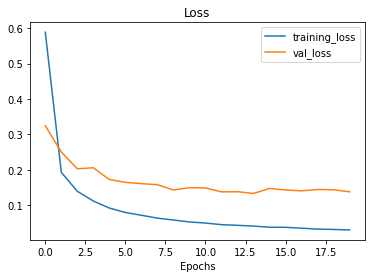

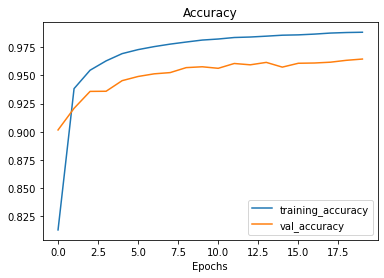

In [15]:
plot_loss_curves(history_8)

## 모델 저장

In [82]:
# model_8.save('/Users/sangjulee1/desktop/HandwrittenCalc_acc_0.9644.H5')

INFO:tensorflow:Assets written to: /Users/sangjulee1/desktop/HandwrittenCalc_acc_0.9644.H5/assets


In [83]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive
